Audit Grouping
===

 - Load (calibrated) ORES scores
 - Load revert probability scores
 - Group in some way (caliper width?)
 - Investigate groupings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
from tqdm import tqdm
import bz2
import sqlite3
import difflib
import gzip
import json
import re
import hashlib
from datetime import datetime
from datetime import timezone
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [3]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [4]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [5]:
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
working_dir = os.path.join(derived_data_dir, 'audit')
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit'

### Load (calibrated) ORES scores

In [6]:
s = datetime.now()
audit_dir = os.path.join(derived_data_dir, 'audit')
calibrated_probs_filepath = os.path.join(audit_dir, 'sample3_ores_scores_calibrated.csv')
ores_df = pd.read_csv(calibrated_probs_filepath)
print(f"{datetime.now() - s}")
len(ores_df)

0:00:19.906027


34289314

In [7]:
ores_df.head()

,rev_id,damaging_prob,damaging_prob_calibrated
0,846835190,0.014069,0.017446
1,923997118,0.597491,0.879206
2,867368228,0.304521,0.266850
3,888337768,0.010122,0.016759
4,917010365,0.013616,0.017366


### Load revert scores

In [85]:
# read the revert scores
s = datetime.now()
audit_dir = os.path.join(derived_data_dir, 'audit')
revert_score_filepath = os.path.join(audit_dir, 'sample3_revert_scores.csv')
revert_score_df = pd.read_csv(revert_score_filepath)
print(f"{datetime.now() - s}")
len(revert_score_df)

0:00:03.684300


4005752

In [86]:
revert_score_df.head()

,rev_id,revert_prob,is_reverted
0,872415232,0.053284,False
1,872415234,0.215013,False
2,872415235,0.008344,False
3,872415236,0.050808,False
4,872415237,0.009443,False


### Load revert metadata

### Merge scores and group

In [87]:
df = pd.merge(ores_df, revert_score_df, on='rev_id')
len(df)

4005140

In [88]:
df.head()

,rev_id,damaging_prob,damaging_prob_calibrated,revert_prob,is_reverted
0,820194840,0.007866,0.016379,0.012434,False
1,822083792,0.069579,0.030595,0.033573,False
2,819435206,0.055102,0.026442,0.025798,False
3,823780514,0.335035,0.333160,0.268014,False
4,824991964,0.020471,0.018619,0.015884,False


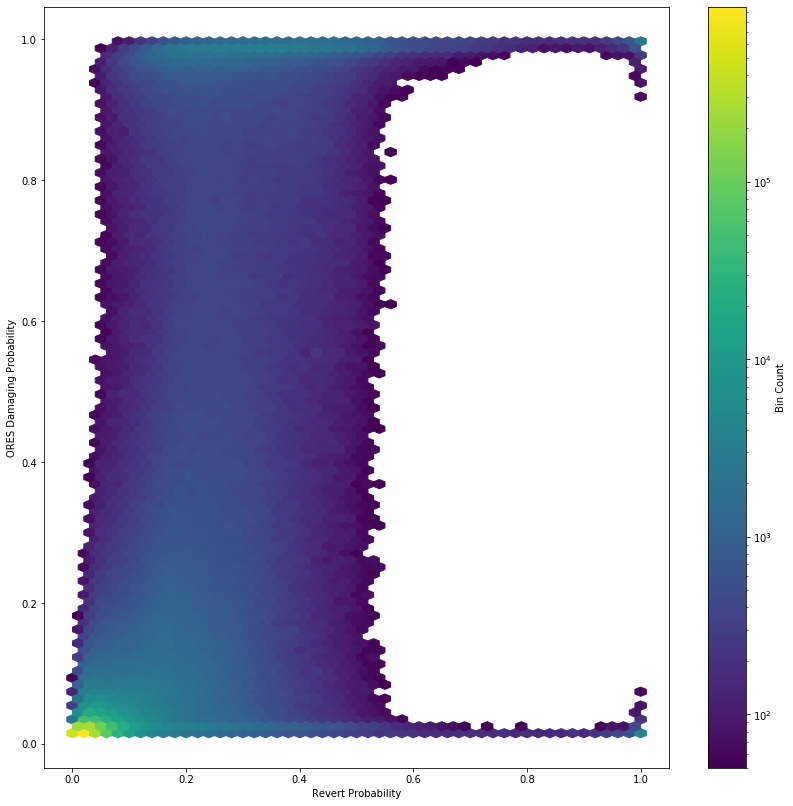

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
hb = plt.hexbin(df.revert_prob, df.damaging_prob_calibrated, bins='log', gridsize=(50,50), mincnt=50)
plt.xlabel('Revert Probability')
plt.ylabel('ORES Damaging Probability')

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Bin Count')

plt.show()

In [90]:
df['revert_group'] = df.revert_prob.map(lambda rp: int(rp * 100))

In [91]:
Counter(df.revert_group).most_common(20)

[(1, 812541),
 (2, 558045),
 (0, 513953),
 (3, 343621),
 (4, 212093),
 (5, 133758),
 (6, 94089),
 (7, 72206),
 (8, 57644),
 (9, 49522),
 (10, 44456),
 (11, 41712),
 (16, 41002),
 (17, 40416),
 (15, 39917),
 (12, 39593),
 (14, 39542),
 (18, 39315),
 (13, 39195),
 (19, 39089)]

In [100]:
xs = []
ys =[]
for group_num, subset in df.groupby('revert_group'):
    pct_reverted = np.sum(subset.is_reverted) / len(subset)
    pct_predicted = (group_num / 100) + 0.005
    xs.append(pct_predicted)
    ys.append(pct_reverted)

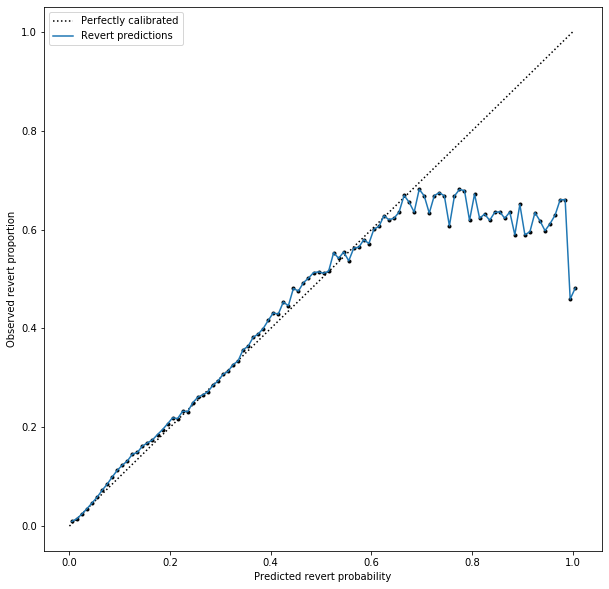

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(xs, ys, label='Revert predictions')
plt.scatter(xs, ys, color='black', marker='.')
plt.legend()
plt.xlabel("Predicted revert probability")
plt.ylabel("Observed revert proportion")
plt.show()

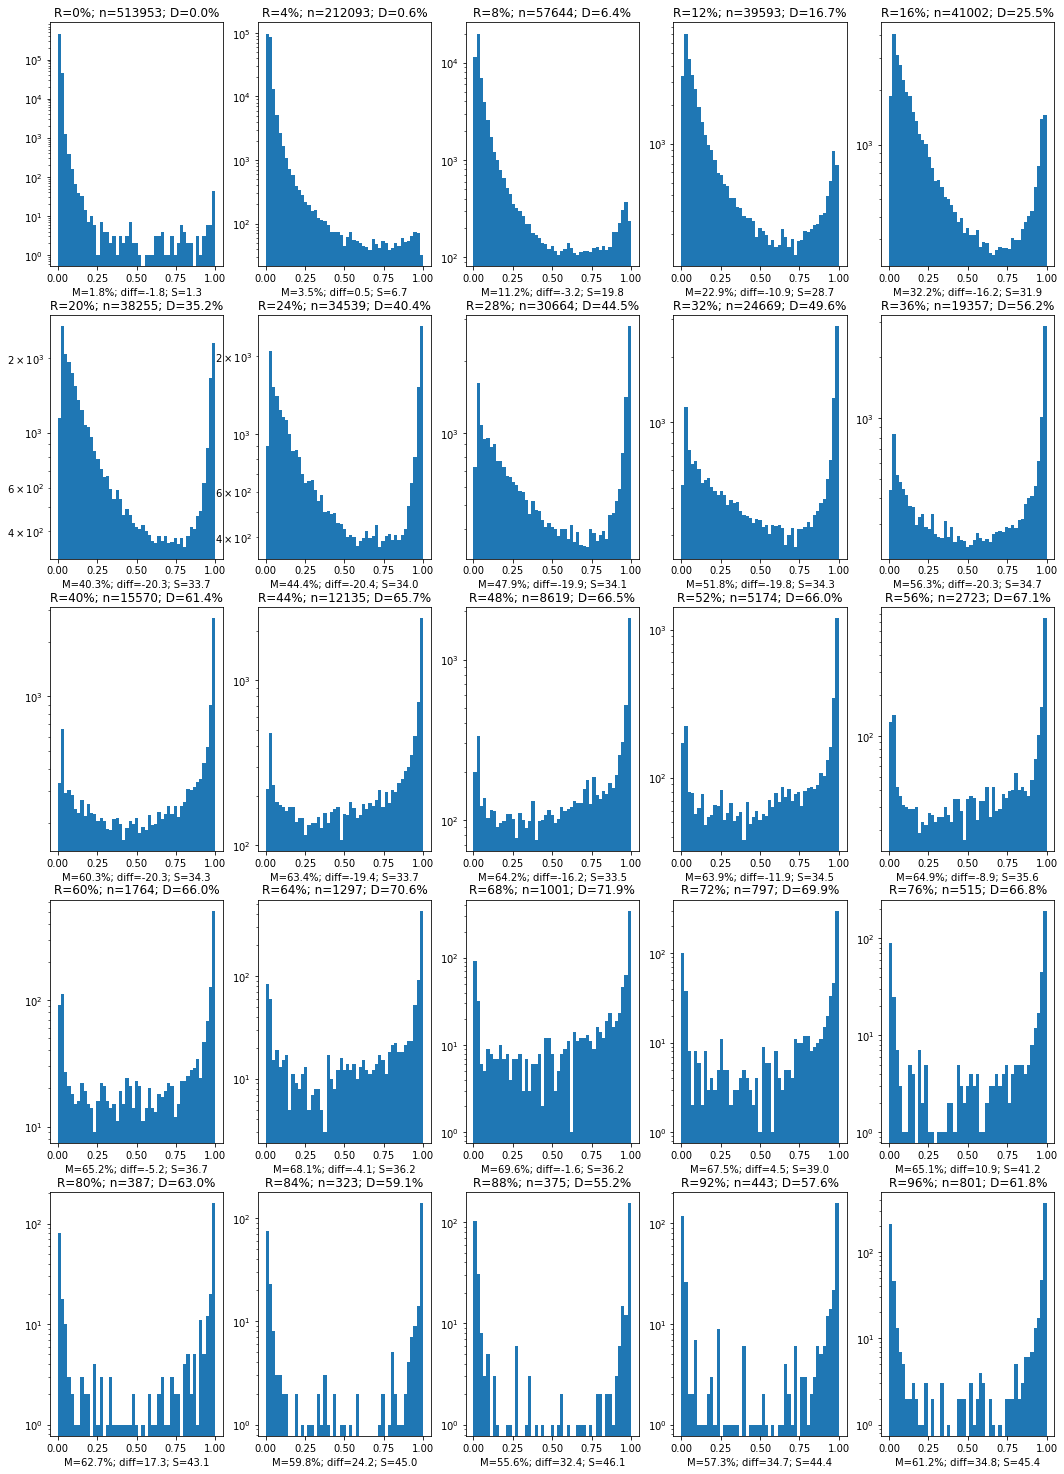

In [103]:
fig, axes = plt.subplots(5, 5, figsize=(18, 26))

bins = np.linspace(0, 1, num=50)

group = 0
for row in axes:
    for ax in row:
        #group = int(np.random.random() * 100)
        subset = df[df.revert_group == group]
        ax.set_title(f"R={group}%; n={len(subset)}; D={np.sum(subset.damaging_prob_calibrated >= 0.5) / len(subset)*100:.1f}%")
        
        ax.hist(subset.damaging_prob_calibrated, bins=bins, log=True)
        
        mean_damaging_prob = np.mean(subset.damaging_prob_calibrated)
        mean_diff = (group / 100) - mean_damaging_prob
        std_damaging_prob = np.std(subset.damaging_prob_calibrated)
        ax.set_xlabel(f'M={mean_damaging_prob*100:.1f}%; diff={mean_diff*100:.1f}; S={std_damaging_prob*100:.1f}')
        
        group += 4

plt.show()

In [108]:
import scipy.stats
d = []
for group_num, subset in df.groupby('revert_group'):
    mean_damaging_prob = np.mean(subset.damaging_prob_calibrated)
    mean_diff = (group_num / 100) - mean_damaging_prob
    std_damaging_prob = np.std(subset.damaging_prob_calibrated)
    #scipy.stats.pearsonr(subset., y)
    d.append({
        'group': group_num,
        'n': len(subset),
        'mean_damaging_prob': mean_damaging_prob,
        'std_damaging_prob': std_damaging_prob,
        'mean_diff': mean_diff,
        'abs_mean_diff': np.abs(mean_diff),
        'rev_sample': ' '.join([str(r) for r in subset.sample(n=5).rev_id]),
        'damaging_rev_sample': ' '.join([str(r) for r in subset[subset.damaging_prob_calibrated >= 0.9].sample(n=5).rev_id]),
        'nondamaging_rev_sample': ' '.join([str(r) for r in subset[subset.damaging_prob_calibrated <= 0.1].sample(n=5).rev_id])
    })
len(d)

101

In [109]:
group_df = pd.DataFrame(d)
len(group_df)

101

In [110]:
group_df.head()

,group,n,mean_damaging_prob,std_damaging_prob,mean_diff,abs_mean_diff,rev_sample,damaging_rev_sample,nondamaging_rev_sample
0,0,513953,0.018003,0.013161,-0.018003,0.018003,825753864 820149116 823728735 819402723 822652887,826245557 825331578 825542100 825867560 826289386,822531390 820856352 820954392 819239873 819348681
1,1,812541,0.019912,0.013971,-0.009912,0.009912,822172945 820615275 819966986 826027189 820984449,825399966 825037109 825473209 825907870 824967893,821788948 819544061 822666773 819938810 821292820
2,2,558045,0.023036,0.025107,-0.003036,0.003036,824938757 824632665 825970336 824022337 826292012,823354196 823051835 819264777 822261428 819272120,821964927 823176102 822900921 820737473 818163453
3,3,343621,0.027879,0.043876,0.002121,0.002121,819974268 825226996 825979484 822970844 820040789,826338383 823973068 824150448 821998169 821601086,821506317 820743959 824502081 824755302 826136979
4,4,212093,0.035179,0.067123,0.004821,0.004821,820229716 824102079 824801777 818775944 821173513,818395186 823574374 822341838 822670715 822653049,822036690 819488144 823459990 820100555 818629674


In [111]:
group_df.sort_values(by='abs_mean_diff', ascending=False)

,group,n,mean_damaging_prob,std_damaging_prob,mean_diff,abs_mean_diff,rev_sample,damaging_rev_sample,nondamaging_rev_sample
99,99,9425,0.398589,0.456845,0.591411,0.591411,819489431 820450289 818107168 820008084 822086860,825980498 824172764 822865571 823537021 824790921,820331103 823907608 824394715 824755597 824073344
100,100,1103,0.413476,0.418919,0.586524,0.586524,824798749 823471103 824596452 824105193 823605162,824036844 823638823 824594182 819453863 824269783,825480969 823510355 819282380 824607626 823749072
98,98,1173,0.599279,0.458514,0.380721,0.380721,825630090 826408385 818583546 822293983 825541535,821841279 819886226 820017734 824044644 824890339,821454486 825174245 825972547 818470199 821148394
93,93,510,0.562920,0.454163,0.367080,0.367080,823153032 819572080 819746077 825814882 819543490,821662275 823172158 819254982 825393345 826240195,823893559 825114088 823006487 824888947 823744124
95,95,688,0.584988,0.458418,0.365012,0.365012,826385660 825375563 825326994 826164367 824130466,821686427 826385440 819814056 825617834 820770657,820047953 819385734 819245484 824130466 826164367
...,...,...,...,...,...,...,...,...,...
70,70,895,0.704404,0.359656,-0.004404,0.004404,819164868 825450351 823132450 822751365 825729722,821096753 826167088 820910605 822308153 819241859,825152389 821832090 821662660 821340850 819392937
6,6,94089,0.063804,0.130952,-0.003804,0.003804,822605866 825893559 823334329 821500452 824992487,823683689 823072303 823886519 822042468 822008423,819784401 819690386 824827800 818531917 823985963
2,2,558045,0.023036,0.025107,-0.003036,0.003036,824938757 824632665 825970336 824022337 826292012,823354196 823051835 819264777 822261428 819272120,821964927 823176102 822900921 820737473 818163453
3,3,343621,0.027879,0.043876,0.002121,0.002121,819974268 825226996 825979484 822970844 820040789,826338383 823973068 824150448 821998169 821601086,821506317 820743959 824502081 824755302 826136979


In [112]:
group_df.sort_values(by='std_damaging_prob', ascending=False)

,group,n,mean_damaging_prob,std_damaging_prob,mean_diff,abs_mean_diff,rev_sample,damaging_rev_sample,nondamaging_rev_sample
88,88,375,0.556225,0.460616,0.323775,0.323775,820097697 824416388 825643050 825355930 826222028,820586872 825918251 819961827 821339404 825204747,825065373 821488124 826004419 823791487 821197665
98,98,1173,0.599279,0.458514,0.380721,0.380721,825630090 826408385 818583546 822293983 825541535,821841279 819886226 820017734 824044644 824890339,821454486 825174245 825972547 818470199 821148394
95,95,688,0.584988,0.458418,0.365012,0.365012,826385660 825375563 825326994 826164367 824130466,821686427 826385440 819814056 825617834 820770657,820047953 819385734 819245484 824130466 826164367
99,99,9425,0.398589,0.456845,0.591411,0.591411,819489431 820450289 818107168 820008084 822086860,825980498 824172764 822865571 823537021 824790921,820331103 823907608 824394715 824755597 824073344
86,86,342,0.568331,0.455925,0.291669,0.291669,825628179 823985295 825548826 821490175 822733928,826202043 826325518 819027376 822840523 825548208,818842971 824407249 823684195 823982081 823585632
...,...,...,...,...,...,...,...,...,...
4,4,212093,0.035179,0.067123,0.004821,0.004821,820229716 824102079 824801777 818775944 821173513,818395186 823574374 822341838 822670715 822653049,822036690 819488144 823459990 820100555 818629674
3,3,343621,0.027879,0.043876,0.002121,0.002121,819974268 825226996 825979484 822970844 820040789,826338383 823973068 824150448 821998169 821601086,821506317 820743959 824502081 824755302 826136979
2,2,558045,0.023036,0.025107,-0.003036,0.003036,824938757 824632665 825970336 824022337 826292012,823354196 823051835 819264777 822261428 819272120,821964927 823176102 822900921 820737473 818163453
1,1,812541,0.019912,0.013971,-0.009912,0.009912,822172945 820615275 819966986 826027189 820984449,825399966 825037109 825473209 825907870 824967893,821788948 819544061 822666773 819938810 821292820


In [84]:
# https://en.wikipedia.org/w/index.php?diff=

In [117]:
group_num = 50
print("damaging")
for link in [f"https://en.wikipedia.org/w/index.php?diff={rev_id}" for rev_id in group_df[group_df.group == group_num].damaging_rev_sample.iloc[0].split(" ")]:
    print(link)
print("nondamaging")    
for link in [f"https://en.wikipedia.org/w/index.php?diff={rev_id}" for rev_id in group_df[group_df.group == group_num].nondamaging_rev_sample.iloc[0].split(" ")]:
    print(link)

damaging
https://en.wikipedia.org/w/index.php?diff=825617802
https://en.wikipedia.org/w/index.php?diff=822970176
https://en.wikipedia.org/w/index.php?diff=822338267
https://en.wikipedia.org/w/index.php?diff=818892503
https://en.wikipedia.org/w/index.php?diff=824997306
nondamaging
https://en.wikipedia.org/w/index.php?diff=818040700
https://en.wikipedia.org/w/index.php?diff=822532996
https://en.wikipedia.org/w/index.php?diff=825510542
https://en.wikipedia.org/w/index.php?diff=826010312
https://en.wikipedia.org/w/index.php?diff=818757526
